In [ ]:
!pip install transformers datasets diffusers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import os
import csv
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from datasets import load_dataset, Dataset


class Data:
    def __init__(self, model_id="kohbanye/pixel-art-style") -> None:
        self.pipe = DiffusionPipeline.from_pretrained(
            model_id, torch_dtype=torch.float16
        )
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(
            self.pipe.scheduler.config
        )
        self.pipe = self.pipe.to("cuda")
        self.pipe.enable_attention_slicing()  # save GPU vram

    def load_prompts(self, n_prompts=2000, ds_path="andyyang/stable_diffusion_prompts_2m") -> Dataset:
        ds = load_dataset(ds_path, split="train")
        ds = ds.filter(lambda x: "by" not in x['text']) # 800k filtered
        ds = ds.filter(lambda x: 10 <= len(x['text']) < 140) # 140 is median len
        k_idx = np.random.randint(low=0, high=len(ds), size=n_prompts).tolist()
        out_ds = ds.select(k_idx)
        out_ds = [prompt['text'].rsplit(",")[0] for prompt in out_ds.to_list()]
        out_ds = [prompt.rsplit(".")[0] for prompt in out_ds]
        print(len(out_ds))
        return [f"{prompt}, pixelartstyle" for prompt in out_ds]

    def batched_text_to_image(self, prompts, batch_size=64) -> None:
        """
        prompt[str]: list of prompts (treat as batch)

        csv: file_name, prompt 
        """
        image_path = "/data/"
        meta_path = "./data/metadata.csv"
        if not os.path.exists(f".{image_path}"):
          os.makedirs(f".{image_path}")
        if not os.path.exists(meta_path):
            with open(meta_path, "a+") as f:
                f.write("file_name, prompt\n") # headers
            f.close()

        dataloader = DataLoader(prompts, batch_size=batch_size)
        idx = 0
        for batch in tqdm(dataloader):
            images = self.pipe(batch).images
            for i, image in enumerate(images):
                image.save(f"./{image_path}{idx}.png")
                with open(meta_path, "a+") as f:
                  row = {"file_name": f"{image_path}{idx}.png", "prompt": batch[i]}
                  dict_writer = csv.DictWriter(f, fieldnames=list(row.keys()))
                  dict_writer.writerow(row)
                f.close()
                idx += 1

    def generation(self):
        prompts = self.load_prompts()
        self.batched_text_to_image(prompts)

    def to_dataset(self, data_dir="./data", hf_path="sunilSabnis/pixelart"):
        """
        convert directory to hf dataset
        """
        dataset = load_dataset("imagefolder", data_dir=data_dir)
        dataset.push_to_hub(hf_path)


In [ ]:
data_pipe = Data()

data_pipe.generation()

2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  3%|▎         | 1/32 [02:01<1:02:38, 121.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▋         | 2/32 [04:01<1:00:26, 120.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  9%|▉         | 3/32 [06:02<58:25, 120.86s/it]  

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▎        | 4/32 [08:03<56:24, 120.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 5/32 [10:04<54:22, 120.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 19%|█▉        | 6/32 [12:05<52:21, 120.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 7/32 [14:06<50:21, 120.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▌       | 8/32 [16:06<48:19, 120.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 28%|██▊       | 9/32 [18:07<46:17, 120.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 31%|███▏      | 10/32 [20:08<44:16, 120.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 11/32 [22:08<42:14, 120.69s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 12/32 [24:09<40:15, 120.76s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 41%|████      | 13/32 [26:10<38:13, 120.71s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 14/32 [28:10<36:12, 120.69s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 47%|████▋     | 15/32 [30:11<34:13, 120.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 16/32 [32:12<32:12, 120.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 53%|█████▎    | 17/32 [34:13<30:10, 120.68s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▋    | 18/32 [36:14<28:11, 120.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 59%|█████▉    | 19/32 [38:14<26:09, 120.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▎   | 20/32 [40:15<24:09, 120.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 21/32 [42:16<22:08, 120.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 69%|██████▉   | 22/32 [44:17<20:07, 120.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 23/32 [46:18<18:07, 120.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 24/32 [48:18<16:06, 120.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 25/32 [50:20<14:06, 120.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 81%|████████▏ | 26/32 [52:21<12:06, 121.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 27/32 [54:22<10:05, 121.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 28/32 [56:23<08:04, 121.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 91%|█████████ | 29/32 [58:24<06:03, 121.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 30/32 [1:00:25<04:02, 121.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 97%|█████████▋| 31/32 [1:02:26<02:01, 121.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 32/32 [1:02:50<00:00, 117.81s/it]


In [ ]:
# data_pipe.to_dataset()
dataset = load_dataset("imagefolder", data_dir="./data")

Resolving data files:   0%|          | 0/2001 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-105a8d6979274771/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset.push_to_hub("sunilSabnis/pixelart")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
df = pd.read_csv("./data/metadata.csv")
df['file_name'] = df['file_name'].apply(lambda x: x.split("/")[-1])

,file_name,prompt
0,0.png,master of magic action scene lightning fire dr...
1,1.png,katniss everdeen as the president of the unite...
2,2.png,nonsensical black empty void in the style of h...
3,3.png,"wax fernando alonso driving a fiat multipla, p..."
4,4.png,"Warhammer 40k Ron Perlman, pixelartstyle"


In [ ]:
df.to_csv("./data/metadata.csv")

In [ ]:
df = pd.read_csv("./data/metadata.csv")

In [ ]:
df

,Unnamed: 0,file_name,prompt
0,0,0.png,master of magic action scene lightning fire dr...
1,1,1.png,katniss everdeen as the president of the unite...
2,2,2.png,nonsensical black empty void in the style of h...
3,3,3.png,"wax fernando alonso driving a fiat multipla, p..."
4,4,4.png,"Warhammer 40k Ron Perlman, pixelartstyle"
...,...,...,...
1995,1995,1995.png,"mario, pixelartstyle"
1996,1996,1996.png,"abraham lincoln taking a selfie, pixelartstyle"
1997,1997,1997.png,"Cate Blanchett as a siren in borderlands, pixe..."
1998,1998,1998.png,"goku with a high top fade, pixelartstyle"


In [ ]:
ds = load_dataset("sunilSabnis/pixelart")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sunilSabnis___parquet/sunilSabnis--pixelart-fd76bf57f264a2f7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

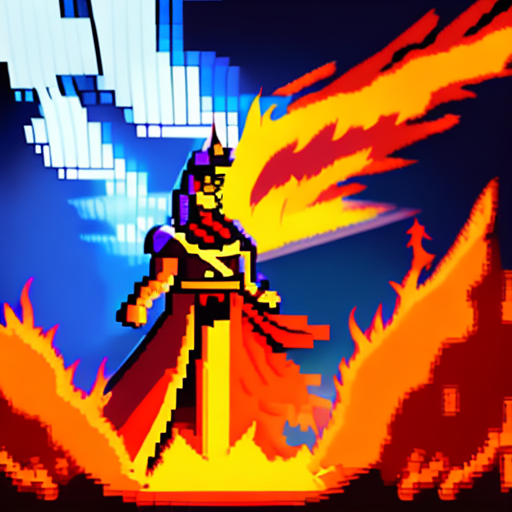

In [ ]:
ds['train'][0]['image']